## Transliteration Baseline From English to Bengali
Authors: Shubajit Saha

[Reference Code](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)


## Data Loading

In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

import urllib.request
import matplotlib.font_manager as mfm


data_source_url = 'https://www.omicronlab.com/download/fonts/Siyamrupali.ttf'
filedata = urllib.request.urlretrieve(data_source_url)
filename = filedata[0]
bengali_font = mfm.FontProperties(fname=filename)
%matplotlib inline

In [0]:
train_url1 = 'https://raw.githubusercontent.com/Bangla-NLP/BLUE-Benchmark/master/data/transliteration/train.tsv'
train_url2 = 'https://raw.githubusercontent.com/Bangla-NLP/BLUE-Benchmark/master/data/transliteration/dictionary_data/dictionary_extracted_processed.tsv'
validation_url = 'https://raw.githubusercontent.com/Bangla-NLP/BLUE-Benchmark/master/data/transliteration/validation.tsv'
validation_avro_output_url = 'https://raw.githubusercontent.com/Bangla-NLP/BLUE-Benchmark/master/data/transliteration/validation_avro.tsv'


train_file1 = tf.keras.utils.get_file('train1.tsv', origin=train_url1)
train_file2 = tf.keras.utils.get_file('train2.tsv', origin=train_url2)
validation_file = tf.keras.utils.get_file('validation1.tsv', origin=validation_url)
validation_avro_output_file = tf.keras.utils.get_file('validation_avro1.tsv', origin=validation_avro_output_url)


In [0]:
train_data = []
with open(train_file1,'r') as fip:
  train_data1 = list(map(lambda x:x.split('\t'),fip.read().splitlines()))
with open(train_file2,'r') as fip:
  train_data2 = list(map(lambda x:x.split('\t'),fip.read().splitlines()))
with open(validation_file,'r') as fip:
  validation_data = list(map(lambda x:x.split('\t'),fip.read().splitlines()))
with open(validation_avro_output_file,'r') as fip:
  validation_avro_output_data = list(map(lambda x:x.split('\t'),fip.read().splitlines()))

### Establish Baseline With Avro

In [0]:
from typing import List
rope = List[str]

def accuracy(target:rope,predicted:rope)->(float,rope,rope):
  if len(target) != len(predicted):
    raise ValueError("target length different from predicted")

  cnt = 0.0
  total = len(target)
  correct = []
  incorrect = []
  for t,p in zip(target,predicted):
    if t == p:
      cnt += 1
      correct.append([t,p])
    else:
      incorrect.append([t,p])
  
  return (cnt*100/total) if total > 0 else 0,correct,incorrect

In [0]:
#validation_data = sorted(validation_data,key=lambda x:x[0])
gold = [g[0] for g in validation_data]
#validation_avro_output_data = sorted(validation_avro_output_data,key=lambda x:x[0])
avro = [a[1] for a in validation_avro_output_data]

In [103]:
acc,correct,incorrect = accuracy(gold,avro)
print("Accuracy of Avro Transliteration engine is: ",acc)

Accuracy of Avro Transliteration engine is:  17.46031746031746


### Data Processing

In [0]:
#Global VARIABLES
MAX_LENGTH = 25

In [105]:
train_data = train_data1 + train_data2
print('#Train Instance: ',len(train_data))
print('#Validation Instance: ',len(validation_data))

#Train Instance:  19153
#Validation Instance:  504


In [106]:
def preprocess_input(w:str)->str:
  w = w.lower().strip()

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z0-9 ]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<' + w + '>'
  return w

def preprocess_target(w:str)->str:
  w = w.lower().strip()

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^\u0980-\u09FF ]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<' + w + '>'
  return w

def prune(w:str)->bool:
  return True if len(w) > MAX_LENGTH else False

print(preprocess_input('ap24551 87$%^'))
print(preprocess_target('amra বাঙ্গালি ১২৩'))

<ap24551 87>
<বাঙ্গালি ১২৩>


In [0]:
def create_dataset(word_pairs:list,include_reverse=False)->(list,list):
  # Remove below data
  for i,w in enumerate(word_pairs):
    if len(w) < 2:
      print(w)
      word_pairs[i] = w[0].split(' ')
  bengali_words = []
  english_words = []
  for w in word_pairs:
    bw = preprocess_target(w[0])
    ew = preprocess_input(w[1])
    if not prune(bw) and not prune(ew):
      bengali_words.append(bw)
      english_words.append(ew)
  
  if include_reverse:
    for w in word_pairs:
      bw = preprocess_target(''.join(reversed(w[0])))
      ew = preprocess_input(''.join(reversed(w[1])))
      if not prune(bw) and not prune(ew):
        bengali_words.append(bw)
        english_words.append(ew)
    
  return english_words,bengali_words

In [108]:
x_train,y_train = create_dataset(train_data,include_reverse=False)
x_val,y_val = create_dataset(validation_data)

print(len(x_train),len(y_train))
print(len(x_val),len(y_val))

18765 18765
504 504


In [109]:
print(list(zip(x_train[-10:],y_train[-10:])))

[('<hyamasring>', '<হ্যামস্ট্রিং>'), ('<hyalo>', '<হ্যালো>'), ('<hyalo ina>', '<হ্যালোইন>'), ('<hrasa>', '<হ্রাস>'), ('<hrasa>', '<হ্রাস>'), ('<hrasa kara>', '<হ্রাস করা>'), ('<hrasakarana>', '<হ্রাসকরণ>'), ('<hresadhbani>', '<হ্রেষাধ্বনি>'), ('<hresadhbani>', '<হ্রেষাধ্বনি>'), ('<hresadhbani>', '<হ্রেষাধ্বনি>')]


In [0]:
def tokenize(lang:list)->tf.keras.preprocessing.text.Tokenizer:
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='',char_level=True,oov_token='?',lower=True)
  lang_tokenizer.fit_on_texts(lang)
  return lang_tokenizer

def process(lang:list,lang_tokenizer:tf.keras.preprocessing.text.Tokenizer)->tf.Tensor:
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
  return tensor

In [0]:
inp_lang =  tokenize(x_train)
x_train_tensor = process(x_train,inp_lang)
x_val_tensor = process(x_val,inp_lang)

targ_lang = tokenize(y_train)
y_train_tensor = process(y_train,targ_lang)
y_val_tensor = process(y_val,targ_lang)

In [112]:
print(x_train_tensor.shape)
print(y_train_tensor.shape)
print(x_val_tensor.shape)
print(y_val_tensor.shape)

(18765, 25)
(18765, 25)
(504, 19)
(504, 17)


# Prepare DataSet and Batches

In [0]:
BUFFER_SIZE = len(x_train_tensor)
BATCH_SIZE = 64

VAL_BUFFER_SIZE = len(x_val_tensor)
VAL_BATCH_SIZE = 32

steps_per_epoch = len(x_train_tensor)//BATCH_SIZE
steps_per_epoch_val = len(x_val_tensor)//VAL_BATCH_SIZE


embedding_dim = 128
units = 256

vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((x_train_tensor, y_train_tensor)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

dataset_val = tf.data.Dataset.from_tensor_slices((x_val_tensor, y_val_tensor)).shuffle(VAL_BUFFER_SIZE)
dataset_val = dataset_val.batch(VAL_BATCH_SIZE, drop_remainder=True)

In [115]:
example_input_batch, example_target_batch = next(iter(dataset_val))
example_input_batch.shape, example_target_batch.shape

(TensorShape([32, 19]), TensorShape([32, 17]))

# Model Building

## Architecture

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.embedding_dropout = tf.keras.layers.Dropout(0.2)

    self.layernorm1 = tf.keras.layers.LayerNormalization()
    self.layernorm2 = tf.keras.layers.LayerNormalization()
    self.gru_cell1 = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   dropout=0.25)
    self.gru1 = tf.keras.layers.Bidirectional(self.gru_cell1, merge_mode='concat', weights=None, backward_layer=None)

    self.gru_cell2 = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   dropout=0.25)
    self.gru2 = tf.keras.layers.Bidirectional(self.gru_cell2, merge_mode='concat', weights=None, backward_layer=None)


  def call(self, x, hidden):
    x = self.embedding(x)
    x = self.embedding_dropout(x)

    output1, state_f, state_b = self.gru1(x, initial_state = hidden)
    output1 = self.layernorm1(output1)

    output2, state_f, state_b = self.gru2(output1)
    output2 = self.layernorm2(output2)

    output = output1+output2

    state = tf.concat([state_f,state_b],axis=1)
    return output, state

  def initialize_hidden_state(self,batch_sz:int,bidirectional=True):
    if bidirectional:
      return [tf.zeros((batch_sz, self.enc_units)),tf.zeros((batch_sz, self.enc_units))]
    else:
      return tf.zeros((batch_sz, self.enc_units))

In [117]:
encoder = Encoder(vocab_inp_size, embedding_dim, units)

# sample input
sample_hidden = encoder.initialize_hidden_state(VAL_BATCH_SIZE,bidirectional=True)
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))
print(sample_hidden.shape)
#encoder.summary()

Encoder output shape: (batch size, sequence length, units) (32, 19, 512)
Encoder Hidden state shape: (batch size, units) (32, 512)
(32, 512)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

In [119]:
attention_layer = BahdanauAttention(256)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (32, 512)
Attention weights shape: (batch_size, sequence_length, 1) (32, 19, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.embedding_dropout = tf.keras.layers.Dropout(0.2)
    self.gru1 = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   dropout=0.25)
    self.layernorm1 = tf.keras.layers.LayerNormalization()

    self.gru2 = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   dropout=0.25)
    self.layernorm2 = tf.keras.layers.LayerNormalization()
    
    self.fc1 = tf.keras.layers.Dense(dec_units)
    self.fc_dropout = tf.keras.layers.Dropout(0.5)
    self.fc = tf.keras.layers.Dense(vocab_size)

    self.layernorm3 = tf.keras.layers.LayerNormalization()
    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    x = self.embedding_dropout(x)

    # passing the concatenated vector to the GRU
    output1, state1 = self.gru1(x)
    output1 = self.layernorm1(output1)

    output2, state2 = self.gru2(output1)
    output2 = self.layernorm1(output2)

    #Residual Connection
    output = output1 + output2
    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    state = state1 + state2
    state = self.layernorm3(state)

    x = self.fc1(output)
    x = self.fc_dropout(x)
    # output shape == (batch_size, vocab)
    x = self.fc(x)

    return x, state, attention_weights

In [121]:
decoder = Decoder(vocab_tar_size, embedding_dim, 2*units)

sample_decoder_output, _, _ = decoder(tf.random.uniform((VAL_BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (32, 77)


In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  # total_batch_loss = tf.reduce_sum(loss_)
  # total_predictions = tf.reduce_sum(mask)+ tf.constant(0.001,dtype=mask.dtype)

  # # print("mask: ",mask.shape,tf.reduce_sum(mask))
  # # print("loss: ",loss_.shape,tf.reduce_sum(loss_))
  # return total_batch_loss/total_predictions

  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
@tf.function
def train_step_with_teacher_forcing(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    
    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss


In [0]:
@tf.function
def train_step_no_teacher_forcing(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    
    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictrain_step_with_teacher_forcingtions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)
      predicted_ids = tf.argmax(predictions,axis=1)

      # Not using teacher forcing
      dec_input = tf.expand_dims(predicted_ids, 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [0]:
import numpy
def train_step_scheduled_sampling(inp, targ, enc_hidden,tf_prob):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    
    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)
      predicted_ids = tf.argmax(predictions,axis=1)

      ep = np.random.random_sample(1)[0]
      if ep < tf_prob:
        # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)
      else:
        # Not using teacher forcing
        dec_input = tf.expand_dims(predicted_ids, 1)
        

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [0]:
@tf.function
def evaluate_step(inp, targ, enc_hidden):
  loss = 0

  enc_output, enc_hidden = encoder(inp, enc_hidden)

  dec_hidden = enc_hidden

  dec_input = tf.expand_dims([targ_lang.word_index['<']] * VAL_BATCH_SIZE, 1)

  # No Teacher Forcing in Evaluation step
  for t in range(targ.shape[1]):
    # passing enc_output to the decoder
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

    loss += loss_function(targ[:, t], predictions)
    predicted_ids = tf.argmax(predictions,axis=1)
    #print(predicted_ids.shape)
    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims(predicted_ids, 1)
    #print(dec_input.shape)

  batch_loss = (loss / int(targ.shape[1]))

  return batch_loss

In [0]:
def evaluate(word):
  attention_plot = np.zeros((MAX_LENGTH,MAX_LENGTH))
  word = preprocess_input(word)
  inputs = [inp_lang.word_index[ch] for ch in word]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=MAX_LENGTH,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = '<'

  hidden = [tf.zeros((1, units)),tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<']], 0)

  for t in range(MAX_LENGTH):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id]

    if targ_lang.index_word[predicted_id] == '>':
      return result, word, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)
  
  return result, word, attention_plot

In [0]:
def get_accuracy(x,y):
  predicted = []
  for inp in x:
    result,word,_  = evaluate(inp)
    #print(word,result)
    predicted.append(result)
  acc,_,_ = accuracy(y,predicted)
  return acc

## Training

In [130]:
# Scheduled Sampling for Sequence Prediction with Recurrent Neural Networks
#https://arxiv.org/pdf/1506.03099.pdf

EPOCHS = 20
#Cirriculum Learning Linear Decay
teacher_forcing = [1-(i+1)*(1.0/EPOCHS) for i in range(EPOCHS)]

training_loss = []
validation_loss = []
min_val_loss = 1e8
max_val_accuracy = 0.0
epochs_since = 0

for epoch in range(EPOCHS):
  epoch_training_loss = 0
  epoch_val_loss = 0

  start = time.time()
  enc_hidden = encoder.initialize_hidden_state(BATCH_SIZE,bidirectional=True)

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    # epsilon = np.random.random_sample(1)[0]
    # if epsilon < teacher_forcing[epoch]:
    #   batch_training_loss = train_step_with_teacher_forcing(inp, targ, enc_hidden)
    # else:
    #   batch_training_loss = train_step_no_teacher_forcing(inp, targ, enc_hidden)

    batch_training_loss = train_step_scheduled_sampling(inp, targ, enc_hidden,teacher_forcing[epoch])

    epoch_training_loss += batch_training_loss
    if batch % 50 == 0:
      print('Epoch {} Batch {} Training Loss {:.4f}'.format(epoch + 1,
                                                   batch, batch_training_loss.numpy()))
  
  epoch_training_loss = epoch_training_loss / steps_per_epoch
                                             
  print('Epoch {} Total Training Loss {:.4f}'.format(epoch + 1,epoch_training_loss))
  print('Time taken for Training 1 epoch {} sec'.format(time.time() - start))


  enc_hidden_val = encoder.initialize_hidden_state(VAL_BATCH_SIZE)
  for (batch, (inp, targ)) in enumerate(dataset_val.take(steps_per_epoch_val)):
    batch_val_loss = evaluate_step(inp, targ, enc_hidden_val)
    epoch_val_loss += batch_val_loss
  
  epoch_val_loss = epoch_val_loss / steps_per_epoch_val
  print('Epoch {} Total Validation Loss {:.4f}'.format(epoch + 1,epoch_val_loss))

  epoch_val_accuracy = get_accuracy(x_val,y_val)
  print('Epoch {} Total Validation Accuracy {:.4f}'.format(epoch + 1,epoch_val_accuracy))

  if epoch_val_accuracy >= max_val_accuracy:
    print("Accuracy Increased. Max till now: ",max_val_accuracy," current accuracy: ",epoch_val_accuracy)
    max_val_accuracy = epoch_val_accuracy
    epochs_since = 0
    print("saving Model")
    checkpoint.save(file_prefix = checkpoint_prefix)
  else:
    epochs_since += 1
    print("Validation Accuracy Did not improve. Current MinMax Accuracy: ",epoch_val_accuracy)
  
  if epochs_since >= 3:
    pass

  training_loss.append(epoch_training_loss)
  validation_loss.append(epoch_val_loss)

Streaming output truncated to the last 5000 lines.
<andrea> <আন্ড্রেট>
<bodmejaji> <বো্মেজাজী>
<nirapottahinotar> <নিরাপত্তাহীনতার>
<ovvyontore> <অভ্যন্তরে>
<nistaar> <নিস্টার>
<motso> <মট্স>
<revolver e> <রিভাভভারই>
<ashuk> <আশুক>
<lini> <আলিনি>
<majhboyoshi> <মাঝ্বয়েশী>
<oddahyer> <দ্ডাহ্যের>
<lima> <আলিম>
<414> <৪১৪>
<shibsenay> <শিবানায়>
<sobmohole> <সব্মহহে>
<yerwara> <যের্বার>
<bhog> <ভোগ>
<obhishapke> <অভিষাপ্কে>
<thalite> <ঠালিটে>
<purkaiter> <পূরকাটিতের>
<nemechilo> <নেমেছিল>
<byjm> <এিজি>
<pyaarichaand> <প্যাটারিকান্ড>
<metiaburuj er> <মেটিয়াবুরুজে>
<adou> <আদে>
<iqbalkeo> <ইকবালকেও>
<salkiar> <সালকিয়ার>
<shrinkholarokkhar> <শ্রিংখোরারকক্ষার>
<bharotkothar> <ভরর্তখার>
<birrao> <বীরার>
<soshorirer> <সশরীর>
<protimamurtir> <প্রতিমামূর্তির>
<greftaarike> <গ্রেফটারিকে>
<jujubhendro> <জুজুন্দ্র>
<kateni> <কাটেনি>
<egoto> <এগট>
<sdads> <ক্ডাড>
<obhijuktorao> <অভিযুক্তরাও>
<laves> <লাভেস>
<shoshi> <শোষী>
<114jon> <১১৪ন>
<drugke> <দ্রুগকে>
<drisshopoter> <দৃষ্পপতের>
<alan> <আলান>
<un

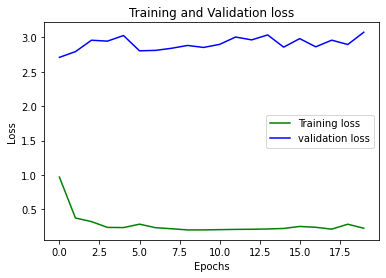

In [131]:
def plot_losses(loss_train,loss_val):
  epochs = range(len(loss_train))
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
plot_losses(training_loss,validation_loss)

## Evaluating

In [0]:
from collections import namedtuple
Path = namedtuple("Path",["score","result","dec_hidden","cur_input"])

def evaluate_with_beam_search(word,beam_width):
  word = preprocess_input(word)
  inputs = [inp_lang.word_index[ch] for ch in word]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=MAX_LENGTH,
                                                           padding='post')
  inputs = tf.convert_to_tensor(inputs)
  hidden = [tf.zeros((1, units)),tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  finished_paths = []
  beamq = [Path(0.0,['<'],tf.identity(enc_hidden),[targ_lang.word_index['<']])]
  max_tries = 100
  while len(beamq) > 0 and len(finished_paths) < beam_width and max_tries > 0:
    max_tries -= 1
    best_path = beamq[0]
    dec_input = tf.expand_dims(best_path.cur_input, 0)
    predictions, dec_hidden, _ = decoder(dec_input,best_path.dec_hidden,enc_out)
    predictions = tf.nn.softmax(predictions,axis=1)
    predicted_ids = tf.argsort(predictions,direction='DESCENDING').numpy()

    for i in range(beam_width):
      cur_result = best_path.result.copy()
      cur_score = best_path.score

      p_id = predicted_ids[0][i]
      p_score = predictions[0][p_id]

      cur_result += targ_lang.index_word[p_id]
      cur_score += tf.math.log(p_score).numpy()
      #print(p_id,p_score,cur_result[-1])

      if cur_result[-1] == '>':
          finished_paths.append((cur_result.copy(),cur_score/len(cur_result)))
      else:
        if len(cur_result) < MAX_LENGTH:
          beamq.append(Path(cur_score,cur_result.copy(),tf.identity(dec_hidden),[p_id]))

    #print(len(beamq))
    beamq = beamq[1:]
    beamq = sorted(beamq,key=lambda p:-1*p.score/len(p.result))
  
  finished_paths = [(p[0],tf.exp(p[1]/len(p[0])).numpy()) for p in finished_paths]
  finished_paths = sorted(finished_paths,key=lambda p:-1*p[1])
  return finished_paths

In [133]:
id = 151
result  = evaluate_with_beam_search(x_val[id],beam_width=5)
greedy,_,_ = evaluate(x_val[id])
print(x_val[id],greedy)
for res in result:
  print(res[0],res[1])

<lini> <লিনী>
['<', 'ল', 'ি', 'ন', 'ী', '>'] 0.9650637922879851
['<', 'ল', 'ি', 'ন', 'ি', '>'] 0.9560577733658774
['<', 'ল', 'ি', 'ন', '>'] 0.8800176432011901
['<', 'ল', 'ী', 'ন', '>'] 0.848114137345611
['<', 'ল', 'ী', '>'] 0.6071892562884522


In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14,'fontproperties':bengali_font}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [0]:
def translate(word:str):
  result, word, attention_plot = evaluate(word)

  print('Input: %s' % (word))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result), :len(word)]
  plot_attention(attention_plot, [ch for ch in word],[ch for ch in result])

In [136]:
# # restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <shubajit>
Predicted translation: <শুবাজিত>


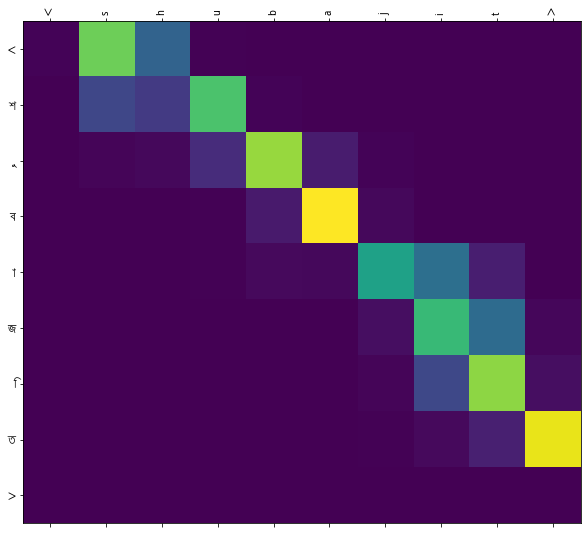

In [151]:
translate('<shubajit>')

In [138]:
predicted = []
for inp in x_val:
  result,word,_  = evaluate(inp)
  print(word,result)
  predicted.append(result)
print(len(y_val),len(predicted))

<koiri> <কইরি>
<purbancholei> <পূর্বন্ছলেই>
<orunabhoke> <ওরুণভাকে>
<sorforaj> <সরফোরাজ>
<osombhobkei> <অসমভভককেই>
<bhalobasa> <ভালোবাস>
<khatatei> <খাটাতেই>
<scholar> <স্চোলার>
<viur> <ভিউর>
<sodbyabohar> <শদ্ব্যবহার>
<rupor> <রূপোর>
<jolotoler> <জলতলের>
<sontrasbader> <সন্ত্রাসাাাবাদের>
<chotkay> <চটকায়>
<triptidayok> <তৃপ্তিদায়ক>
<pujo> <পুজো>
<harryke> <হারিরকে>
<aloknath> <আলোকনা>
<gayatri> <গায়াত্রী>
<bichokhoner> <বিচোখনের>
<sthaanei> <স্থাটেে>
<angel er> <অংলেরের>
<constableke> <কনস্টাবলেকে>
<sarbochchostore> <সর্বছছসরতে>
<talikate> <তালিকাতে>
<boyeri> <বয়েরি>
<patakaguli> <পতককাগুলি>
<paper> <পাপের>
<shibiro> <শিবিরও>
<kothata> <কোথাা>
<ekmatro> <একমাত্রও>
<unnawayer> <উন্নায়য়ের>
<ujjho ee> <উজ্ঝোই>
<robisyarer> <রবিস্যারের>
<fincher> <ফিনছের>
<slok> <স্লোক>
<therapist> <থেরাপিস্ট>
<einsteinder> <ইইসস্টেইনের>
<sebishoye> <সেবিশয়ে>
<striker> <স্ট্রীকের>
<choritrabhineta> <ছোরিত্রাভীনেত>
<school ke> <স্চোলকে>
<jatrisurakshar> <জাত্রীসূরক্ষার>
<bangalianay> <বাঙ্গালায়ায়>
<rajkuma

In [139]:
acc,correct,incorrect = accuracy(y_val,predicted)
print("Accuracy of current trained Model: ",acc)

Accuracy of current trained Model:  17.063492063492063


In [140]:
predicted = []
for i,inp in enumerate(x_val):
  print("processing: ",i)
  result  = evaluate_with_beam_search(inp,beam_width=3)
  if len(result) <1  or len(result[0]) < 2:
    print(i,inp)
    p,_,_ = evaluate(inp)
  else:
    p = ''.join(result[0][0])
  #print(inp,p)
  predicted.append(p)

processing:  0
processing:  1
processing:  2
processing:  3
processing:  4
processing:  5
processing:  6
processing:  7
processing:  8
processing:  9
processing:  10
processing:  11
processing:  12
processing:  13
processing:  14
processing:  15
processing:  16
processing:  17
processing:  18
processing:  19
processing:  20
processing:  21
processing:  22
processing:  23
processing:  24
processing:  25
processing:  26
processing:  27
processing:  28
processing:  29
processing:  30
processing:  31
processing:  32
processing:  33
processing:  34
processing:  35
processing:  36
processing:  37
processing:  38
processing:  39
processing:  40
processing:  41
processing:  42
processing:  43
processing:  44
processing:  45
processing:  46
processing:  47
processing:  48
processing:  49
processing:  50
processing:  51
processing:  52
processing:  53
processing:  54
processing:  55
processing:  56
processing:  57
processing:  58
processing:  59
processing:  60
processing:  61
processing:  62
pr

In [141]:
## Beam Search Accuracy
acc,correct,incorrect = accuracy(y_val,predicted)
print("Accuracy of current trained Model: ",acc)

Accuracy of current trained Model:  16.865079365079364


In [142]:
for i in range(len(predicted)):
  print("Query: ",x_val[i],"Predicted: ",predicted[i]," Gold: ",y_val[i])

Query:  <koiri> Predicted:  <কইরি>  Gold:  <কৈরি>
Query:  <purbancholei> Predicted:  <পূর্বন্ছলেই>  Gold:  <পূর্বাঞ্চলেই>
Query:  <orunabhoke> Predicted:  <ওরুণভাকে>  Gold:  <অরুণাভকে>
Query:  <sorforaj> Predicted:  <সরফোরাজ>  Gold:  <সরফরাজ>
Query:  <osombhobkei> Predicted:  <অসমভভবকেই>  Gold:  <অসম্ভবকেই>
Query:  <bhalobasa> Predicted:  <ভালোবাস>  Gold:  <খাতাতেই>
Query:  <khatatei> Predicted:  <খাটাতেই>  Gold:  <খাতাতেই>
Query:  <scholar> Predicted:  <স্চোলার>  Gold:  <স্কলার>
Query:  <viur> Predicted:  <ভিউর>  Gold:  <ভিউর>
Query:  <sodbyabohar> Predicted:  <শদ্ব্যাবহার>  Gold:  <সদ্ ব্যবহার>
Query:  <rupor> Predicted:  <রূপোর>  Gold:  <রূপোর>
Query:  <jolotoler> Predicted:  <জলতলের>  Gold:  <জলতলের>
Query:  <sontrasbader> Predicted:  <সন্ত্রাসাাবাদের>  Gold:  <সন্ত্রাসবাদের>
Query:  <chotkay> Predicted:  <চটকায়>  Gold:  <চটকায়>
Query:  <triptidayok> Predicted:  <তৃপ্তিদায়ক>  Gold:  <তৃপ্তিদায়ক>
Query:  <pujo> Predicted:  <পুজো>  Gold:  <পুজো>
Query:  <harryke> Predicted:  <হারিরক

## Saving Model

In [143]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [144]:
!ls "/content/gdrive/My Drive"

 Algorithm1.zip		     modelV1_decoder.h5
 Algorithm2.zip		     modelV1_encoder.h5
 bengali_tokenizerV1.pkl     modelV2_decoder.h5
 bengali_tokenizerV2.pkl     modelV2_encoder.h5
'Colab Notebooks'	     NeuralNetwork.zip
 CryptoCurrency.zip	     newIdMapping.tsv
 english_tokenizerV1.pkl     NLP.zip
 english_tokenizerV2.pkl     Relativity.zip
 GameTheory1.zip	    'Shubajit Saha-Intern.xlsx'
 GameTheory2.zip	    'Shubajit Saha-Intern.xlsx.gsheet'
 HAN-fasttext-kaggle.ipynb   Shubajit_Saha.pdf


In [0]:
encoder.save_weights('/content/gdrive/My Drive/model_best_encoder.h5')
decoder.save_weights('/content/gdrive/My Drive/model_best_decoder.h5')

In [0]:
import pickle
pickle.dump(inp_lang,open('/content/gdrive/My Drive/english_tokenizer_best.pkl','wb'))
pickle.dump(targ_lang,open('/content/gdrive/My Drive/bengali_tokenizer_best.pkl','wb'))